In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm


from sklearn import tree


from IPython.display import Image


import pydotplus
from sklearn import ensemble

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [61]:
#assign data frames
employees_df = pd.read_csv('Data/IMB_HR.csv')

In [62]:
#examine the data frame

print(
    employees_df.head(),
    employees_df.info(),
    employees_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [63]:
#Check for missing values

missing_values_ratios = (employees_df.isnull().sum()/employees_df.isnull().count())
missing_values_ratios.sort_values(ascending=False).head()

YearsWithCurrManager    0.0
EmployeeCount           0.0
JobLevel                0.0
JobInvolvement          0.0
HourlyRate              0.0
dtype: float64

In [64]:
Attrition_numeric = []

for idx, val in enumerate(employees_df['Attrition']):
    if val == 'Yes':
        Attrition_numeric.append(1)
    else:
        Attrition_numeric.append(0)
        
employees_df['Attrition_numeric'] = Attrition_numeric

In [65]:
#check the correlation of the numerical variables with the target
np.abs(employees_df[employees_df.select_dtypes(['int64', 'float64']).columns].iloc[:,1:].corr().loc[:,"Attrition_numeric"]).sort_values(ascending=False).head(20)



Attrition_numeric           1.000000
TotalWorkingYears           0.171063
JobLevel                    0.169105
YearsInCurrentRole          0.160545
MonthlyIncome               0.159840
YearsWithCurrManager        0.156199
StockOptionLevel            0.137145
YearsAtCompany              0.134392
JobInvolvement              0.130016
JobSatisfaction             0.103481
EnvironmentSatisfaction     0.103369
DistanceFromHome            0.077924
WorkLifeBalance             0.063939
TrainingTimesLastYear       0.059478
DailyRate                   0.056652
RelationshipSatisfaction    0.045872
NumCompaniesWorked          0.043494
YearsSinceLastPromotion     0.033019
Education                   0.031373
MonthlyRate                 0.015170
Name: Attrition_numeric, dtype: float64

In [66]:
np.abs(employees_df[['Attrition_numeric', 'TotalWorkingYears', 'JobLevel', 'YearsInCurrentRole', 'MonthlyIncome',
            'YearsWithCurrManager', 'StockOptionLevel', 'YearsAtCompany', 'JobInvolvement', 'JobSatisfaction',
            'EnvironmentSatisfaction']].corr())

,Attrition_numeric,TotalWorkingYears,JobLevel,YearsInCurrentRole,MonthlyIncome,YearsWithCurrManager,StockOptionLevel,YearsAtCompany,JobInvolvement,JobSatisfaction,EnvironmentSatisfaction
Attrition_numeric,1.000000,0.171063,0.169105,0.160545,0.159840,0.156199,0.137145,0.134392,0.130016,0.103481,0.103369
TotalWorkingYears,0.171063,1.000000,0.782208,0.460365,0.772893,0.459188,0.010136,0.628133,0.005533,0.020185,0.002693
JobLevel,0.169105,0.782208,1.000000,0.389447,0.950300,0.375281,0.013984,0.534739,0.012630,0.001944,0.001212
YearsInCurrentRole,0.160545,0.460365,0.389447,1.000000,0.363818,0.714365,0.050818,0.758754,0.008717,0.002305,0.018007
MonthlyIncome,0.159840,0.772893,0.950300,0.363818,1.000000,0.344079,0.005408,0.514285,0.015271,0.007157,0.006259
YearsWithCurrManager,0.156199,0.459188,0.375281,0.714365,0.344079,1.000000,0.024698,0.769212,0.025976,0.027656,0.004999
StockOptionLevel,0.137145,0.010136,0.013984,0.050818,0.005408,0.024698,1.000000,0.015058,0.021523,0.010690,0.003432
YearsAtCompany,0.134392,0.628133,0.534739,0.758754,0.514285,0.769212,0.015058,1.000000,0.021355,0.003803,0.001458
JobInvolvement,0.130016,0.005533,0.012630,0.008717,0.015271,0.025976,0.021523,0.021355,1.000000,0.021476,0.008278
JobSatisfaction,0.103481,0.020185,0.001944,0.002305,0.007157,0.027656,0.010690,0.003803,0.021476,1.000000,0.006784


## PCA Model

In [67]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(employees_df.select_dtypes(['int64', 'float64']))

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)


Covariance Matrix:
 [[ 1.00068074e+00  1.06681999e-02 -1.68726795e-03  2.08175347e-01
   0.00000000e+00 -1.01523735e-02  1.01533349e-02  2.43030753e-02
   2.98402581e-02  5.09951134e-01 -4.89520722e-03  4.98193474e-01
   2.80702626e-02  2.99838730e-01  3.63605842e-03  1.90519156e-03
   5.35711626e-02  0.00000000e+00  3.75352466e-02  6.80843695e-01
  -1.96341755e-02 -2.15046570e-02  3.11520689e-01  2.13045985e-01
   2.16660756e-01  2.02226171e-01 -1.59313383e-01]
 [ 1.06681999e-02  1.00068074e+00 -4.98873105e-03 -1.68178739e-02
   0.00000000e+00 -5.10251446e-02  1.83673491e-02  2.33973381e-02
   4.61662796e-02  2.96835414e-03  3.05918186e-02  7.71230534e-03
  -3.22035087e-02  3.81794067e-02  2.27191327e-02  4.73618517e-04
   7.85137203e-03  0.00000000e+00  4.21714845e-02  1.45246194e-02
   2.45421224e-03 -3.78738155e-02 -3.40779498e-02  9.93877603e-03
  -3.32516049e-02 -2.63811246e-02 -5.66905569e-02]
 [-1.68726795e-03 -4.98873105e-03  1.00068074e+00  2.10561495e-02
   0.00000000e+00  3

In [68]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[-2.76621480e-01  2.35536096e-03 -1.70570138e-03 -7.73555725e-02
  0.00000000e+00  7.89603396e-03 -5.71768707e-03  9.91445219e-03
 -2.87051417e-03 -3.80878996e-01  5.73900579e-03 -3.72686725e-01
 -4.92636267e-03 -4.64968064e-02  1.51884458e-02  1.13185385e-04
 -1.67078243e-02  0.00000000e+00 -1.96674914e-02 -4.01180786e-01
  9.52459922e-03 -1.43404690e-02 -3.88443137e-01 -3.34464463e-01
 -2.93157923e-01 -3.28855861e-01  1.10099638e-01]
Eigenvalue 1: 4.704253607684259
----------------------------------------
Eigenvector 2: 
[-0.28289124 -0.03633755  0.05715844 -0.14702835  0.         -0.01279124
 -0.030309   -0.04528387 -0.04966748 -0.1903745   0.03488902 -0.199443
 -0.06230507 -0.37809056  0.42499544  0.44393781 -0.08756215  0.
  0.0054414  -0.16947229  0.04190153  0.01293809  0.2172156   0.28186696
  0.20449938  0.28195415  0.01019821]
Eigenvalue 2: 1.8375502352990567
----------------------------------------
Eigenvector 3: 
[ 0.2549922   0.06111709  0.03065113  0.10060

In [81]:
eig_val_cov_df['eigenvalues']=pd.DataFrame(eig_val_cov)

eig_val_cov_df

,0,eigenvalues
0,4.704254,4.704254
1,1.837550,1.837550
2,1.756872,1.756872
3,0.048422,0.048422
4,0.141448,0.141448
5,0.203299,0.203299
6,0.225829,0.225829
7,0.279997,0.279997
8,0.529940,0.529940
9,0.509669,0.509669


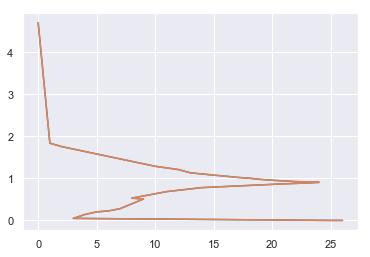

           0  eigenvalues
0   4.704254     4.704254
1   1.837550     1.837550
2   1.756872     1.756872
10  1.287988     1.287988
12  1.209343     1.209343
13  1.133065     1.133065
15  1.077629     1.077629
16  1.052480     1.052480
17  1.024507     1.024507
18  1.005151     1.005151
19  0.975614     0.975614
20  0.955195     0.955195
22  0.924029     0.924029
24  0.906229     0.906229
23  0.890765     0.890765
21  0.870504     0.870504
14  0.780756     0.780756
11  0.686485     0.686485
8   0.529940     0.529940
9   0.509669     0.509669
7   0.279997     0.279997
6   0.225829     0.225829
5   0.203299     0.203299
4   0.141448     0.141448
3   0.048422     0.048422
25  0.000000     0.000000
26  0.000000     0.000000


In [83]:
# print scree plot
plt.plot(eig_val_cov_df.sort_values("eigenvalues", ascending=False))
plt.show()

print(eig_val_cov_df.sort_values("eigenvalues", ascending=False))

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.1880421 0.0732806 0.0702026]


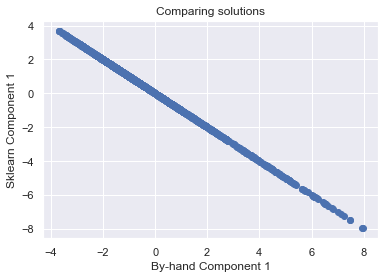

In [84]:
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [85]:
#X is the feature set
X = Y_sklearn

#Y is the target
Y = employees_df.Attrition

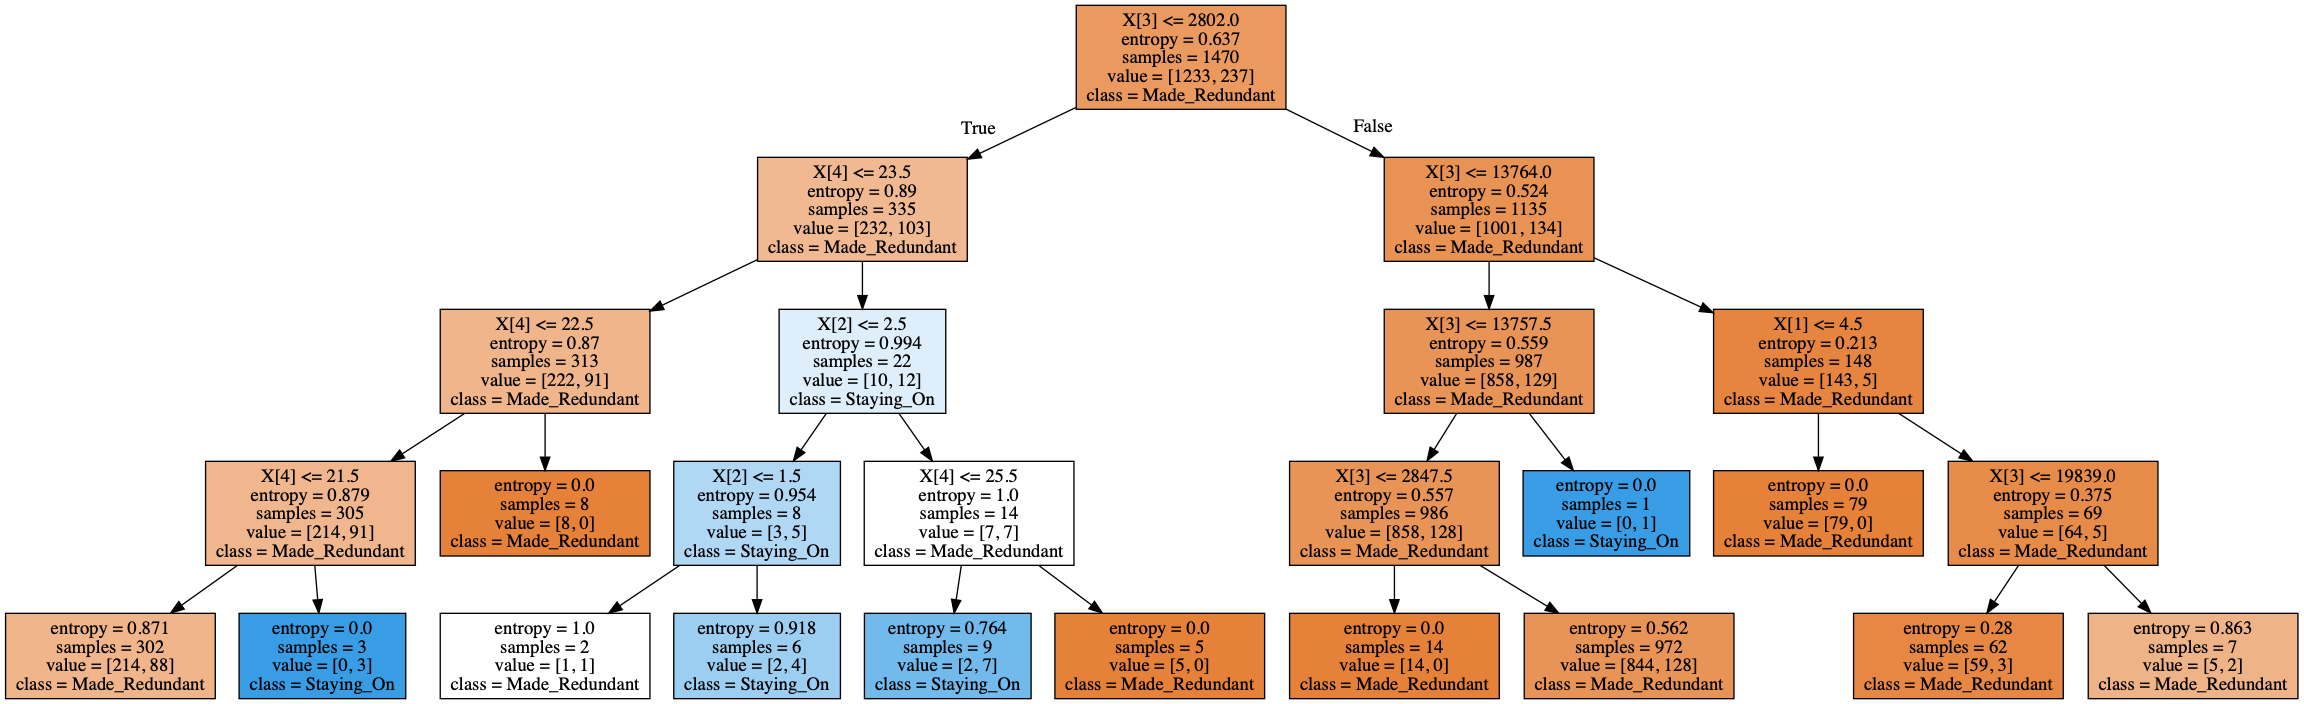

In [89]:
# Initialize and train our Decision Tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
)
decision_tree.fit(X, Y)

# Render our Tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    class_names=['Made_Redundant', 'Staying_On'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [90]:
print(cross_val_score(decision_tree, X, Y, cv=10))
print('The 10-fold cross validation average is ', cross_val_score(decision_tree, X, Y, cv=10).mean())

[0.83108108 0.83783784 0.83108108 0.82993197 0.86394558 0.82993197
 0.84353741 0.84246575 0.84246575 0.85616438]
The 10-fold cross validation average is  0.8381045568912496


## Non-PCA Models

In [88]:
#X is the feature set
X = employees_df[['TotalWorkingYears', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'DistanceFromHome']]

#Y is the target
Y = employees_df.Attrition

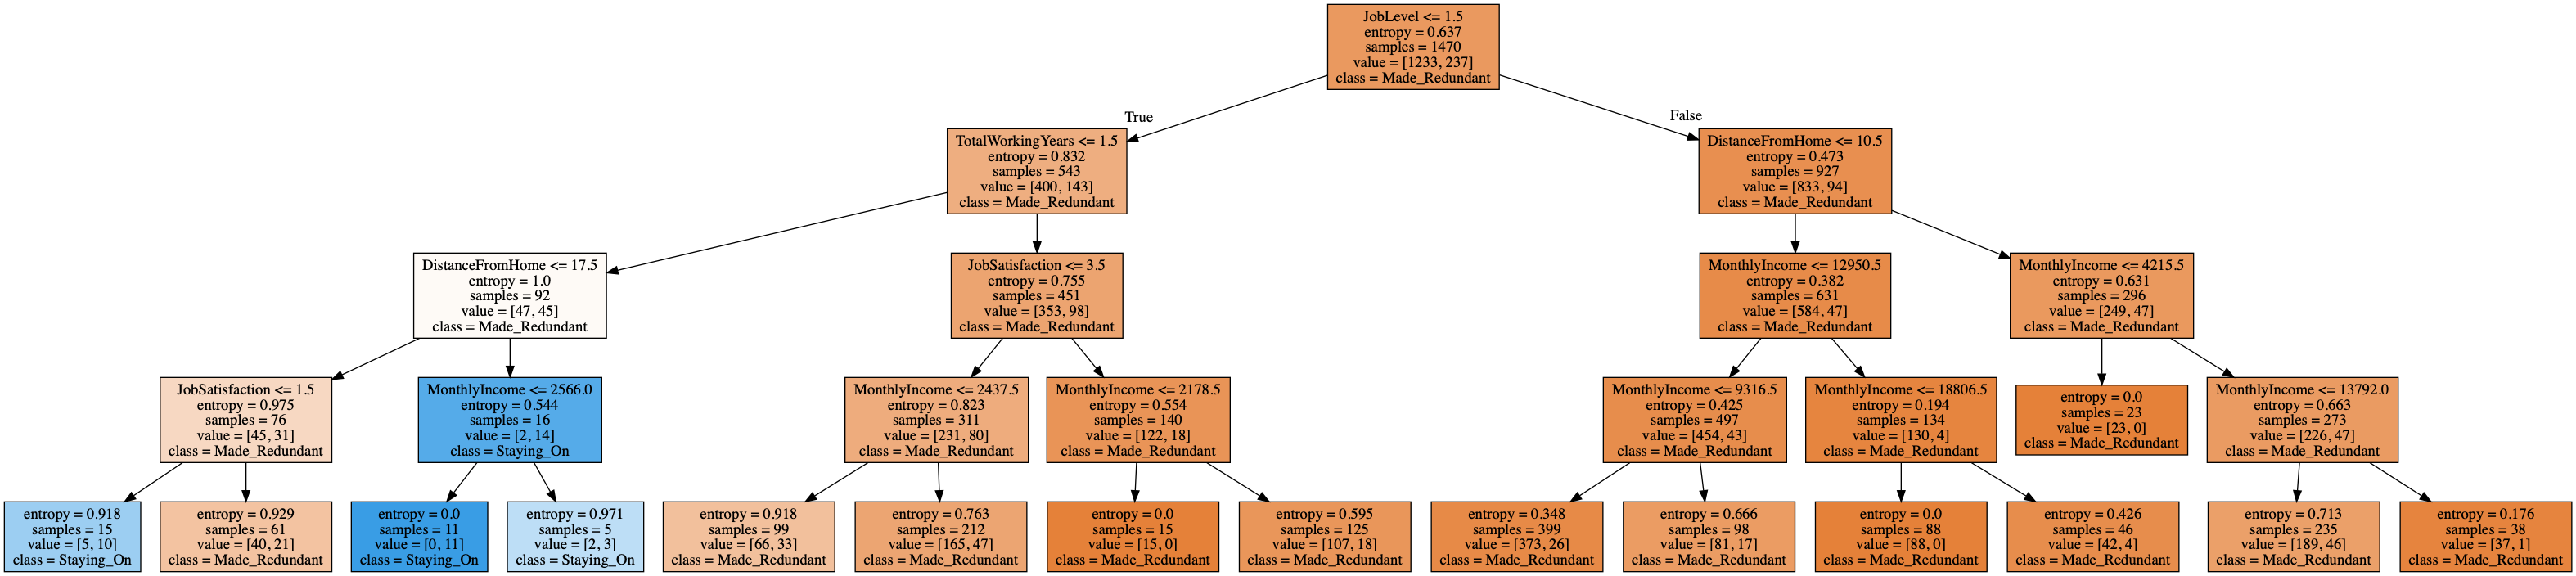

In [30]:
# Initialize and train our Decision Tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=4,
)
decision_tree.fit(X, Y)

# Render our Tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Made_Redundant', 'Staying_On'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [31]:
print(cross_val_score(decision_tree, X, Y, cv=10))
print('The 10-fold cross validation average is ', cross_val_score(decision_tree, X, Y, cv=10).mean())

[0.83108108 0.84459459 0.84459459 0.83673469 0.84353741 0.83673469
 0.83673469 0.84931507 0.84931507 0.84246575]
The 10-fold cross validation average is  0.8415107657279869


In [32]:
# Initialize and train our Random Forest Classifier.
rfc = ensemble.RandomForestClassifier()

print(cross_val_score(rfc, X, Y, cv=10))
print('The 10-fold cross validation average is ', cross_val_score(rfc, X, Y, cv=10).mean())

[0.79054054 0.83108108 0.81756757 0.83673469 0.81632653 0.80272109
 0.81632653 0.81506849 0.82876712 0.84246575]
The 10-fold cross validation average is  0.8170294700627382
